In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split

seed = 88
tf.compat.v1.set_random_seed
np.random.seed(seed)

---------------------

# Retrieving and Preprocess Data

In [2]:
import glob 

roi_path = '/home/kevinteng/Desktop/Python-benchmarkingdata/'
roi_list = glob.glob(roi_path+'*_ROImask.npy')

for i in roi_list:
    print(i)

/home/kevinteng/Desktop/Python-benchmarkingdata/DG-13-3-8-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/DG-13-7-12-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/DG-13-7-16-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/DG-13-8-16-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/7-12-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/7-16-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/DG-13-8-8-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/DG-13-8-11-17_ROImask.npy
/home/kevinteng/Desktop/Python-benchmarkingdata/Dg-13-8-18-17_ROImask.npy


In [3]:
imgs_path = '/home/kevinteng/Desktop/project/jpg_to_npy/'
img_list = []

NEW_SIZE = 100
IMG_SIZE = NEW_SIZE

#for both dg13 and dg21
for imgs in sorted(os.listdir(imgs_path)):
    print(imgs)
    img_path = os.path.join(imgs_path,imgs)
    #load data from path and cast to float32
    img_ds = np.load(img_path).astype('float32')
    #resize image
    re_imgs = utils.resize(img_ds, NEW_SIZE)
    #Dimension for network should include the color channel 
    re_imgs = np.expand_dims(re_imgs, axis = -1)
    img_list.append(re_imgs)

DG 13_7-12-17_preprocessed_dF.npy
DG 13_8-11-17_preprocessed_dF.npy
DG 13_8-16-17_preprocessed_dF.npy
DG 13_8-18-17_preprocessed_dF.npy
DG 13_8-3-17_preprocessed_dF.npy
DG 13_8-8-17_preprocessed_dF.npy
DG 21_7-12-17_preprocessed_dF.npy
DG 21_8-11-17_preprocessed_dF.npy
DG 21_8-3-17_preprocessed_dF.npy
DG 21_8-8-17_preprocessed_dF.npy


In [4]:
rois_path = '/home/kevinteng/Desktop/project/ROI_means/'
roi_list = []

#for both dg13 and dg21
for roi in sorted(os.listdir(rois_path)):
    print(roi)
    roi_path = os.path.join(rois_path, roi)
    roi = np.load(roi_path).astype('float32')
    re_roi = cv2.resize(roi, (NEW_SIZE, NEW_SIZE))
    re_roi = np.expand_dims(re_roi, axis = -1)
    roi_list.append(re_roi)

dg-13-7-12-17ROIs.mat_ROImask.npy
dg-13-8-11-17ROIs.mat_ROImask.npy
dg-13-8-16-17ROIs.mat_ROImask.npy
dg-13-8-18-17ROIs.mat_ROImask.npy
dg-13-8-3-17ROIs.mat_ROImask.npy
dg-13-8-8-17ROIs.mat_ROImask.npy
dg-21-7-12-17ROIs.mat_ROImask.npy
dg-21-8-11-17ROIs.mat_ROImask.npy
dg-21-8-3-17ROIs.mat_ROImask.npy
dg-21-8-8-17ROIs.mat_ROImask.npy


In [4]:
print(len(img_list)==len(roi_list))
print('Number of samples:',len(roi_list))

True
Number of samples: 10


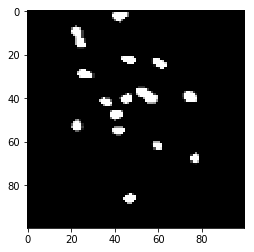

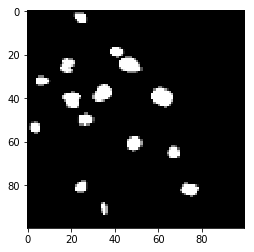

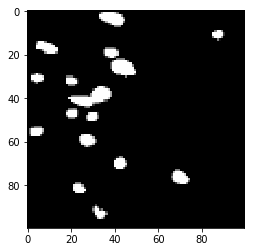

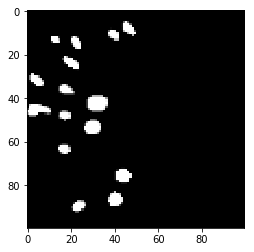

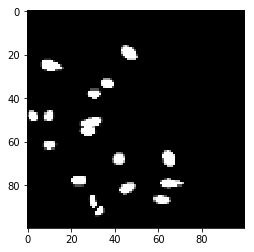

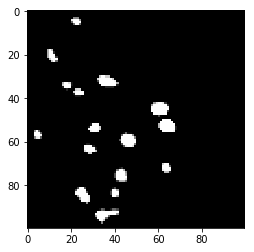

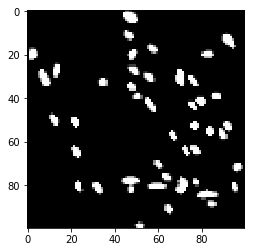

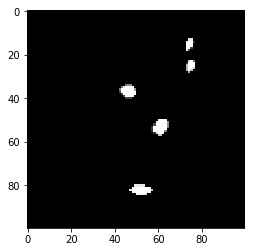

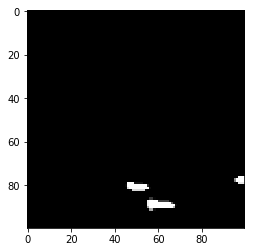

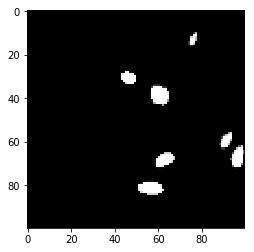

In [5]:
for i in range(len(roi_list)):
    plt.imshow(np.squeeze(roi_list[i]), cmap = 'gray')
    plt.show()

----------------------------------------------------------


# Model

In [6]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block


l1_coeff = 0.99
#filters_layer = [16, 32, 64, 32, 16]
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', kernel_regularizer = True, batch_norm = True,
                                   l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu', kernel_regularizer = True,
                         batch_norm = True, l1_coeff = l1_coeff)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03
        
        

## Build Model

In [7]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv
L1 kernel regularizer is activate!


-----------------------------------------------------------------

## Train Model

In [8]:
from utils_model import img_mean, min_max_norm

#hyperparameter
BATCH_SIZE = 8
lr = 0.001
#loss function
loss_fn = tf.losses.MeanSquaredError()
#optimizer 
opt = tf.optimizers.Adam(lr)

@tf.function
def train(batched_imgs, mean_roi, img_size):
    with tf.GradientTape() as tape:
        stack_batch = tf.zeros((img_size,img_size))
        sums = 0
        
        #loop for batches 
        for img_batch in batched_imgs:
            stack = tf.zeros((img_size,img_size))
            
            #feed the network with batches 
            conv_img = model(img_batch)
            #take the mean of the batch 
            batch_mean = tf.reduce_mean(conv_img, 0)
            #stack the number of batch for each loop in number of batches
            stack_batch+= tf.squeeze(batch_mean)
            sums+=1
        
        #total mean of 
        mean_img=stack_batch/tf.cast(sums, dtype = tf.dtypes.float32)
        #ensure that the size of the images match during loss calculation
        mean_img=tf.reshape(mean_img, [img_size, img_size, 1])
        xent = loss_fn(mean_roi, mean_img)

    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, mean_img, grads

ori_list = [] #original image list
loss_list = [] #loss list
zip_list = [] #list for zip containing mean images with its corresponding mean roi
de_list = [] #mean image fromt the network list
out_roi_list = []

epochs = 0

while epochs < 20:

    for i in range(len(roi_list)):
        batch_imgs = utils.batch_dataset(img_list[i], BATCH_SIZE, IMG_SIZE)
        xent, mean_img, grads =train(batch_imgs, roi_list[i], IMG_SIZE)    
        de_list.append(mean_img)
        out_roi_list.append(roi_list[i])
        loss_list.append(xent)

    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))
    print("Gradient min:{}, max:{}".format(np.min(grads[0]), np.max(grads[0])))
    print()
    epochs+=1

Epochs  0, Loss: 0.033075377345085144
Gradient min:-0.0064585949294269085, max:0.005021893419325352

Epochs  1, Loss: 0.024999024346470833
Gradient min:-0.00011860318772960454, max:0.0002654709096532315

Epochs  2, Loss: 0.02522757649421692
Gradient min:-6.080955790821463e-05, max:0.00011114573862869292

Epochs  3, Loss: 0.025266053155064583
Gradient min:-5.1210572564741597e-05, max:8.795923349680379e-05

Epochs  4, Loss: 0.02526174858212471
Gradient min:-5.5254735343623906e-05, max:9.127415978582576e-05

Epochs  5, Loss: 0.025238951668143272
Gradient min:-6.527294317493215e-05, max:0.00010571112215984613

Epochs  6, Loss: 0.025202706456184387
Gradient min:-7.823254418326542e-05, max:0.00012485237675718963

Epochs  7, Loss: 0.02515900507569313
Gradient min:-8.801872172625735e-05, max:0.00015269093273673207

Epochs  8, Loss: 0.025136500597000122
Gradient min:-9.492977551417425e-05, max:0.0002635325363371521

Epochs  9, Loss: 0.025211866945028305
Gradient min:-0.00018060003640130162, max

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[8,66,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while_grad/body/_291/gradients/model/coord_conv_5/conv2d_5/Conv2D_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[while_grad/LoopCond/_404/_128]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[8,66,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while_grad/body/_291/gradients/model/coord_conv_5/conv2d_5/Conv2D_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_9911]

Function call stack:
train -> train


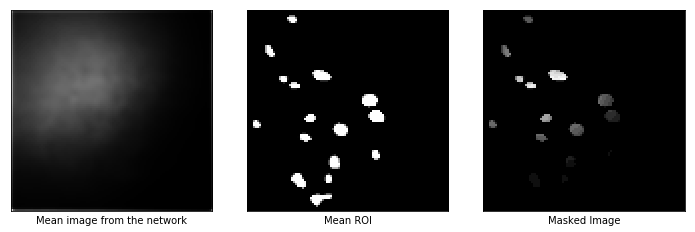

Loss: 0.025362188
Dice coefficient:  0.031430954062329236



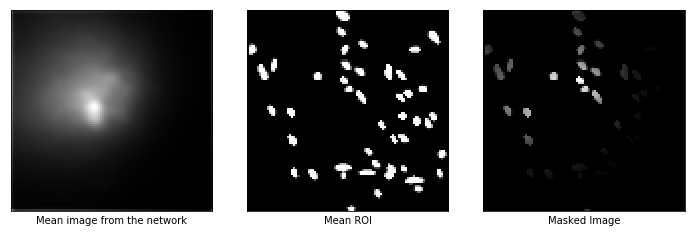

Loss: 0.028723748
Dice coefficient:  0.04034917183590263



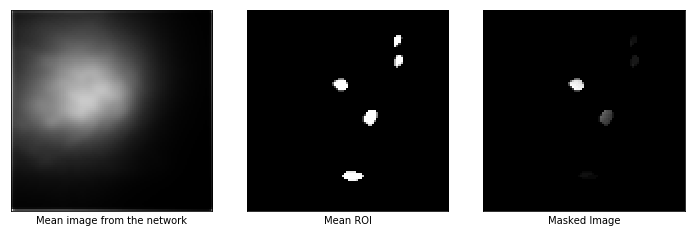

Loss: 0.041860204
Dice coefficient:  0.02543949916616415



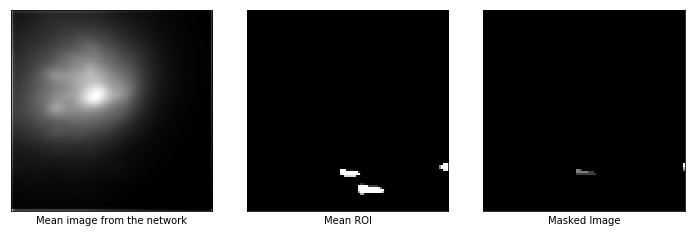

Loss: 0.045489818
Dice coefficient:  0.0017643647519705278



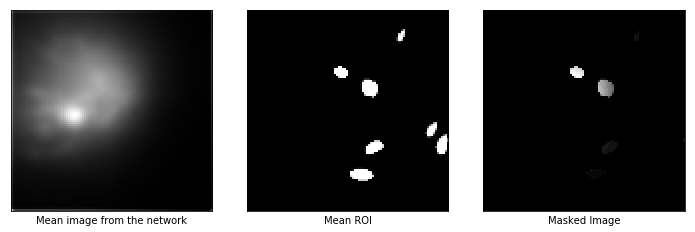

Loss: 0.035833
Dice coefficient:  0.027930141626011804


In [9]:
from utils import masked_img, dice_coef_py, MSE_image
from utils_vis import plot_comparison

#plot for mean image of last 10 steps w.r.t mean roi 
last_n_steps = 5
for i in range(last_n_steps):
    mean_image = de_list[len(de_list) - last_n_steps + i]
    mean_roi = roi_list[len(roi_list) - last_n_steps + i]
    mean_image = np.asarray(mean_image) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    
    #plot
    inp_imgs = [mean_image , mean_roi, masked_image]
    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - last_n_steps + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))

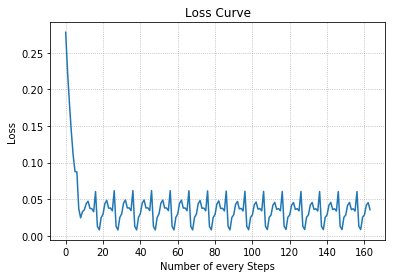

In [10]:
utils_vis.plot_loss(loss_list)

-------------------------------------------------

# Predict

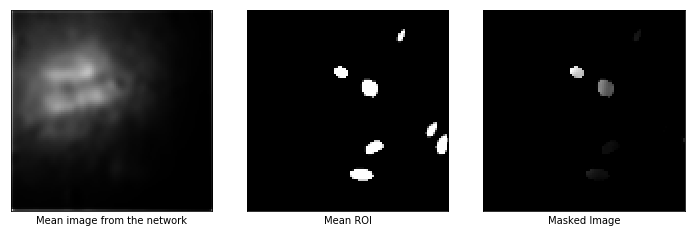

MSE for predicted image:  0.06344386596679688
Dice coefficient:  0.032852828869351404



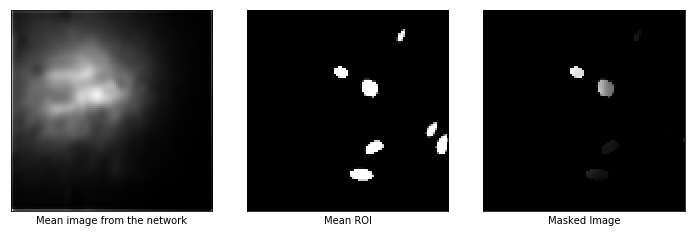

MSE for predicted image:  0.08839615478515625
Dice coefficient:  0.041806386013611446



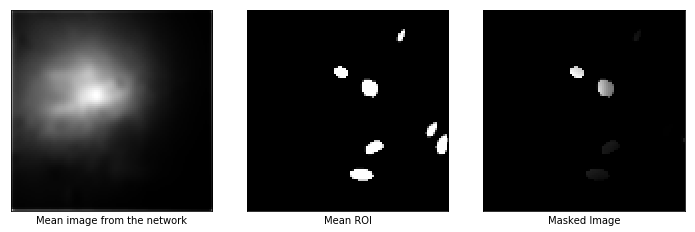

MSE for predicted image:  0.0875168701171875
Dice coefficient:  0.04561453220145293



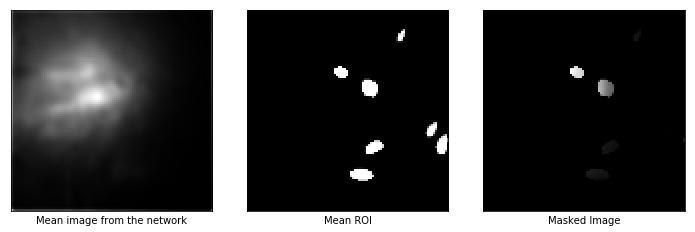

MSE for predicted image:  0.08199985961914062
Dice coefficient:  0.04167054406078812



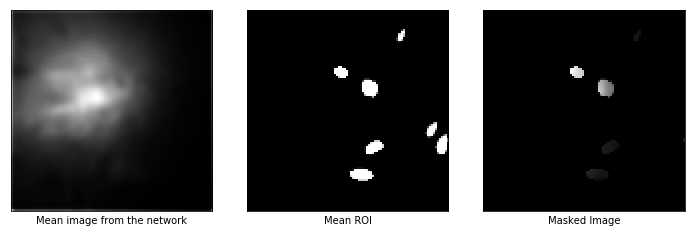

MSE for predicted image:  0.08990729370117187
Dice coefficient:  0.04046547523982864


In [11]:
sums = 0
slices = 20 #slices of image from image stack 
n = 5

#create data generator for test set
ds_test = tf.data.Dataset.from_tensor_slices(img_list[2]).batch(slices)

for i, (test_batch) in enumerate(ds_test):
    assert test_batch.shape[0] == slices

    conv_img = model(test_batch)
    mean_img = img_mean(conv_img, IMG_SIZE)
    mean_img = min_max_norm(mean_img)

    mean_image = np.asarray(mean_img) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    inp_imgs = [np.squeeze(mean_img), mean_roi, masked_image]

    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions, n_col = 3,figsize = (10,10))

    print('MSE for predicted image: ', MSE_image(mean_img, mean_roi, IMG_SIZE))
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))
    
    sums+=1
    
    #plot only n images for prediction
    if sums == n:
        break

-----------------------------------------------

# Visualizing Feature Maps

In [12]:
from utils_vis import layers_dict, feature_maps, plot_feature_maps, layers_name

layer_dict = layers_dict(model)
layer_name = layers_name(model)

input_1
coord_conv_1
batch_normalization
activation
coord_conv_3
batch_normalization_1
activation_1
coord_conv_5
activation_2


In [13]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
# layer_output = layer_dict[layer_name].output

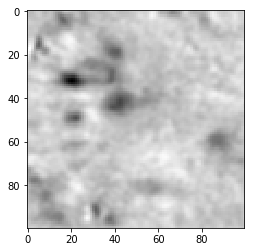

In [15]:
mean_img_ori = utils.mean_image(img_list[2], IMG_SIZE)
#apply min max norm for mean image
mean_img_ori = utils.min_max_norm(mean_img_ori)
mean_img_ori = np.expand_dims(mean_img_ori, -1)
# taking the mean over all stacks as input
test_img = np.asarray(tf.expand_dims(mean_img_ori, 0)) #(1, img size, img size, 1)
#test_img = tf.expand_dims(test_img, -1) #(1, img size, img size, 1)
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

## Visualizing Last Layer of Feature Maps

Shape of feature maps: (1, 100, 100, 64)
Number of feature maps in layer:  64


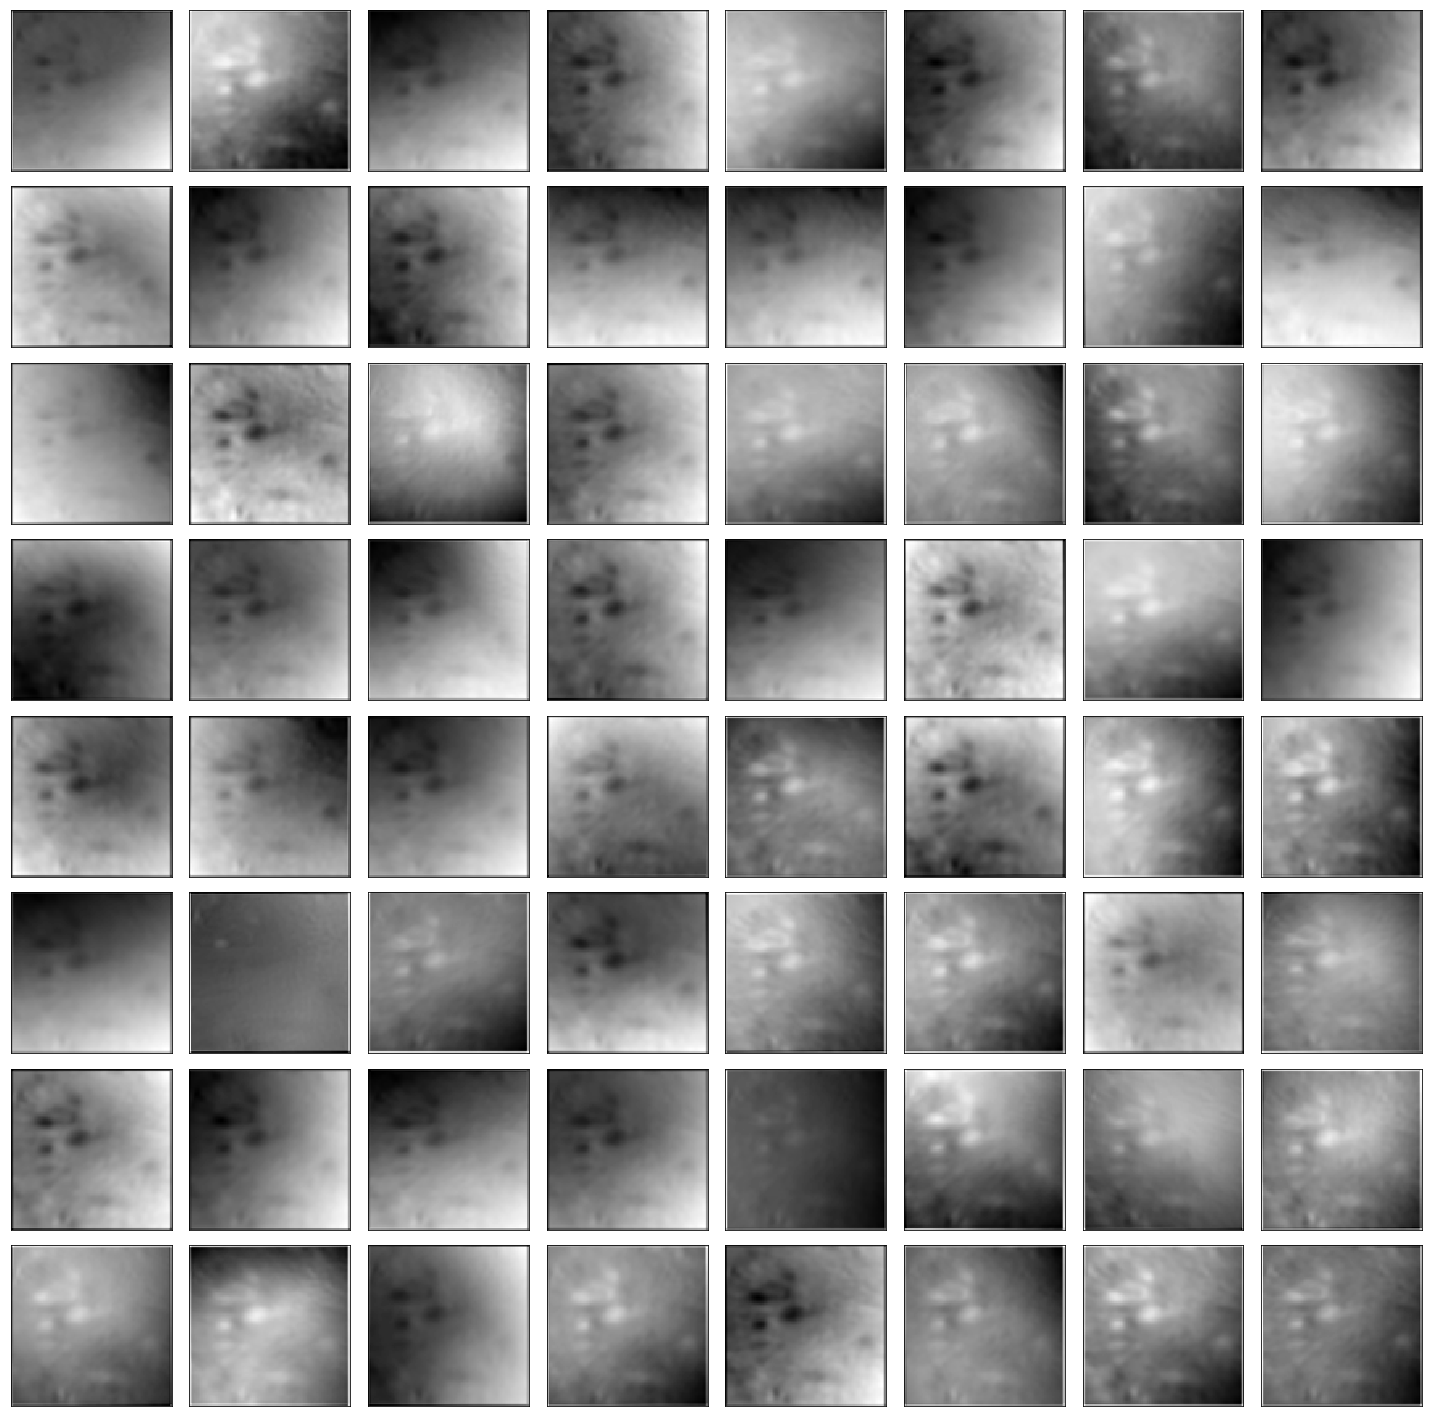

In [16]:
test_map = feature_maps(model, '{}_3'.format(layer_name), test_img)
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

## Visualizing First Layer of Feature Maps

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


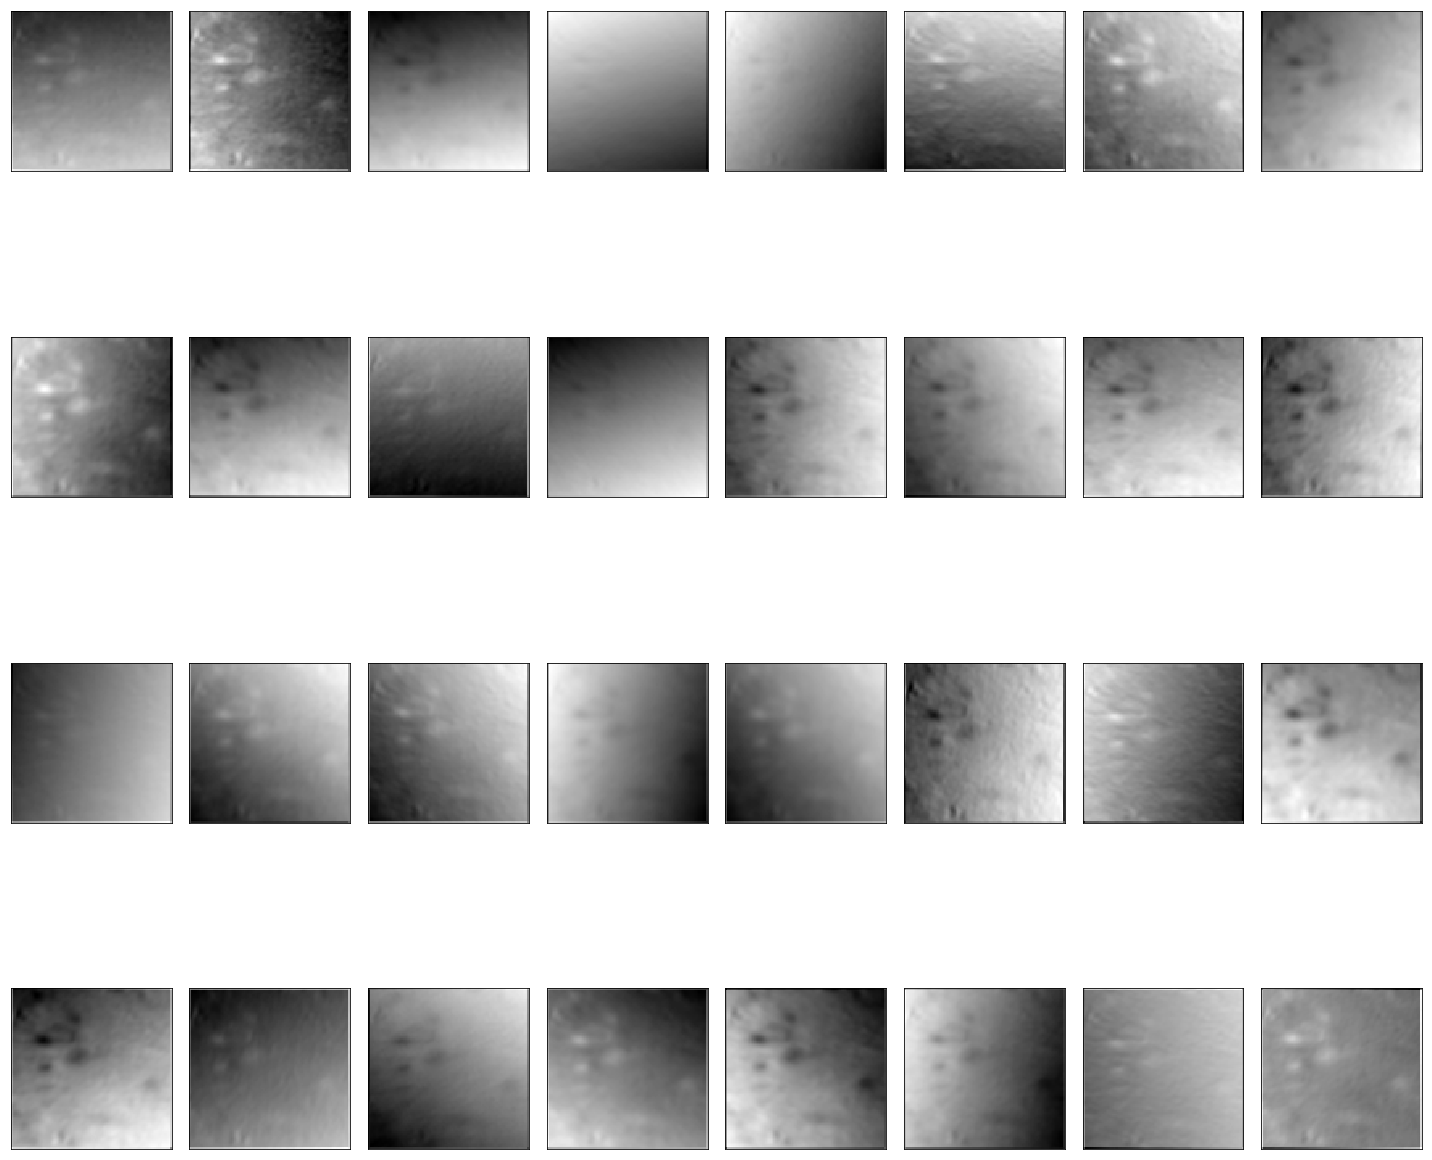

In [17]:
test_map02 = feature_maps(model, '{}_1'.format(layer_name), test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

--------------------------------

# Appendix

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
coord_conv_1 (CoordConv)     (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
coord_conv_3 (CoordConv)     (None, 100, 100, 64)      19648     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0     